In [77]:
from os import walk
import os
import pandas as pd
import subprocess
import sys
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
import time
import json
import re
import urllib2
import unicodedata
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize

wordnet_tags = ['n', 'v', 'a', 's', 'r']
%matplotlib inline


# The main code, built from testing, is in the cell immediately below. 

In [162]:
# from http://brandonrose.org/clustering



from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
stemmer = SnowballStemmer("english")
lemmer = WordNetLemmatizer()
wordnet_tags = ['n', 'v', 'a', 's', 'r']

def tokenize_and_stem_n_lem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    ''' 
    Old code gave seperate lists for lem and stem; I lemmed, then just stemmed the result
    #stems = [stemmer.stem(t) for t in filtered_tokens]
    #lems = [lemmer.lemmatize(l) for l in filtered_tokens]
    '''
    stems = [stemmer.stem(lemmer.lemmatize(l)) for l in filtered_tokens]
    
    #return stems,lems
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [262]:
path        = os.path.abspath(os.getcwd())
TESTDIR     = os.path.normpath(os.path.join(os.path.expanduser("~"),"projects","LC3-Creations", "examples","KDDsample"))

corpus = {}

start_time = time.time()
for dirName, subdirList, fileList in walk(TESTDIR):
        for fileName in fileList:
            if fileName.startswith('p') and fileName.endswith('.pdf'):
                a = unicode(subprocess.check_output(['pdf2txt.py',str(os.path.normpath(os.path.join(TESTDIR,fileName)))]),errors='ignore')
                document = unicodedata.normalize('NFKD', a).encode('ascii','ignore')
                # Getting title
                title = re.findall("^[^\\n\\n]+",document)[0]
                
                # Getting the abstract
                try:
                    abstract = re.findall (r'\n\n(Abstract|ABSTRACT)([^]]*)\n\n',document[:2000])[0]
                except IndexError:
                    abstract = re.findall (r'(Abstract|ABSTRACT)([^]]*)',document[:2000])[0][1]
                except IndexError:
                    abstract = "We are unable to parse the abstract of %s, with title %s; Check file for abstract" % (fileName,title)

                else :
                    abstract = "We are unable to parse the abstract of %s, with title %s; Check file for abstract" % (fileName,title)

                if isinstance(abstract, tuple):
                    abstract = re.sub('[\s]'," ",abstract[1])
                elif isinstance(abstract,list):
                    abstract = re.sub('[\s]'," ",abstract[1])
                elif isinstance(abstract,str):
                    abstract = re.sub('[\s]'," ", abstract)
                
                else:
                    abstract = "We are unable to parse the abstract of %s, with title %s; Check file for abstract" % (fileName,title)

        
                
                    
                # Extracts section with names and email addresses only
                section  = re.findall (r'\n\n([^]]*)\n\n(Abstract|ABSTRACT)',document[:2000])

                type(section[0][0])

                if isinstance(section, list):
                    section = re.sub('[\s]'," ",section[0][0])
                else:
                    section = re.sub('[\s]'," ",section)
                    

                # Code to extract entities from top section of pdf and store a relationship tree
                tagged = nltk.pos_tag(nltk.word_tokenize(section))
                entities = nltk.chunk.ne_chunk(tagged)
                
                # Another entity extractor
                st = StanfordNERTagger('/Users/linwood/stanford-corenlp-full-2015-04-20/classifiers/english.conll.4class.distsim.crf.ser.gz',
					   '/Users/linwood/stanford-corenlp-full-2015-04-20/stanford-corenlp-3.5.2.jar',
					   encoding='utf-8')
                tokenized_text = word_tokenize(section)
                stanentities = st.tag(tokenized_text)
                
                # Calls function to lemmatize and stem the document; stores the result
                tokenize_and_stem_n_lem(abstract);

                '''
                This gives seperate lists for lem and stem; replacement code stores combin
                # Creates the json document format to store the files
                corpus[str(fileName)]={}
                corpus[str(fileName)]={'Title':title,'Abstract':abstract,'Entities':entities, 
                                       "Stanford ER":stanentities, "Stems": tokenize_and_stem_n_lem(abstract)[0], 
                                      "Lems": tokenize_and_stem_n_lem(abstract)[1]}'''
                
                # Creates the json document format to store the files
                corpus[str(fileName)]={}
                corpus[str(fileName)]={'Title':title,'Abstract':abstract,'Entities':entities, 
                                       "Stanford ER":stanentities, "Stems": tokenize_and_stem_n_lem(abstract)}
                print ".",

IndexError: list index out of range

In [257]:
re.sub('[\s]'," ",a)

u'Inferring Gas Consumption and Pollution Emissions of   Vehicles throughout a City    Jingbo Shang1,2,*, Yu Zheng2,+, Wenzhu Tong3,2,*, Eric Chang2, Yong Yu1   1Dept. of Computer Science & Engineering, Shanghai Jiao Tong University   2Microsoft Research, No.5 Danling Street, Haidian District, Beijing 100080, China   3Computer School of Wuhan University, Wuhan, Hubei, China   {v-jishan, yuzheng, v-wetong, echang}@microsoft.com, yyu@apex.sjtu.edu.cn    a direct result, is strategically important to modeling urban traffic, gas  consumption, and pollution emission, in order to help save energy and  protect the environment [19]. For instance, if we were to know the gas  consumption  for  traveling  any  road  segment  at  any  time,  we  can  suggest cost-efficient driving routes and identify road segments where  gas  is  being  wasted  significantly.  Such  knowledge  can  impact  authorities  decision  making  on  improving  a  citys  transportation  infrastructure.  In  the  meantime,  

In [246]:
re.findall (r'(Abstract|ABSTRACT)([^]]*)',document[:2000])

[]

In [248]:
try:
    abstract = re.findall (r'\n\n(Abstract|ABSTRACT)([^]]*)\n\n',document[:2000])[0]
except IndexError:
    abstract = re.findall (r'(Abstract|ABSTRACT)([^]]*)',document[:2000])[0][1]
except IndexError:
    abstract = re.findall()
else:
    abstract = re.findall (r'(Abstract|ABSTRACT)([^]]*)',document[:2000])[0][1]
    
if isinstance(abstract, tuple):
    abstract = re.sub('[\s]'," ",abstract[1])
elif isinstance(abstract,list):
    abstract = re.sub('[\s]'," ",abstract[1])
elif isinstance(abstract,str):
    abstract = re.sub('[\s]'," ", abstract)
else:
    abstract = re.sub('[\s]'," ",abstract)
        
abstract

IndexError: list index out of range

In [225]:
a
document
abstract[0]

'\n'

In [252]:
re.findall (r'\n \n([^]]*\n)',a[:2000])

[]

In [166]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print 'there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame'

there are 901 items in vocab_frame


# Placeholder to see the output of the code above; make sure it does what I want; this will be converted and stored as json document

In [167]:
# remove semicolon to see output
corpus.keys()

['p279.pdf',
 'ptest.pdf',
 'p299.pdf',
 'p309.pdf',
 'p289.pdf',
 'p259.pdf',
 'p269.pdf',
 'p59.pdf',
 'p319.pdf',
 'p29.pdf',
 'p19.pdf',
 'p39.pdf']

Example of how to access values in document store and attributes of each document for processing

In [51]:
corpus['p59.pdf'].keys()

['Title', 'Abstract', 'Entities', 'Stems', 'Lems', 'Stanford ER']

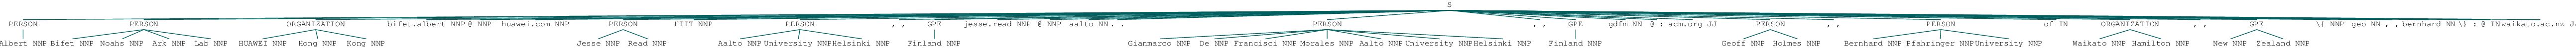

In [6]:
corpus['p59.pdf']['Entities']

# Testing/building individual compents happens below; then I paste it above

In [7]:
# Convert document from unicode to string 

import unicodedata
document = unicodedata.normalize('NFKD', a).encode('ascii','ignore')
document[:2500]

'Using TF-IDF to Determine Word Relevance in Document Queries \n\nJuan Ramos \nDepartment of Computer Science, Rutgers University, 23515 BPO Way, Piscataway, NJ, 08855 \n \n \n\nJURAMOS@EDEN.RUTGERS.EDU \n\nAbstract \n\nIn this paper, we examine the results of applying \nTerm  Frequency  Inverse  Document  Frequency \n(TF-IDF) to determine what words in a corpus of \ndocuments might be more favorable to use in a \nquery.    As  the  term implies, TF-IDF  calculates \nvalues for each word in a document through an \ninverse proportion of the frequency of the word \nin  a  particular  document  to  the  percentage  of \ndocuments  the  word  appears  in.    Words  with \nhigh  TF-IDF  numbers \nstrong \nrelationship  with  the  document  they  appear  in, \nsuggesting that if that word were to appear in a \nquery, the document could  be  of interest to the \nuser.    We  provide  evidence  that  this  simple \nalgorithm  efficiently  categorizes  relevant  words \nthat can enhance query r

In [8]:
# Getting title
title = re.findall("^[^\\n\\n]+",document)[0]
title

# Getting the abstract
abstract = re.findall (r'\n\n(Abstract|ABSTRACT)([^]]*)\n\n',document[:2000])[0]

if isinstance(abstract, tuple):
    abstract = re.sub('[\s]'," ",abstract[1])
else:
    abstract = re.sub('[\s]'," ",abstract)
abstract

'   In this paper, we examine the results of applying  Term  Frequency  Inverse  Document  Frequency  (TF-IDF) to determine what words in a corpus of  documents might be more favorable to use in a  query.    As  the  term implies, TF-IDF  calculates  values for each word in a document through an  inverse proportion of the frequency of the word  in  a  particular  document  to  the  percentage  of  documents  the  word  appears  in.    Words  with  high  TF-IDF  numbers  strong  relationship  with  the  document  they  appear  in,  suggesting that if that word were to appear in a  query, the document could  be  of interest to the  user.    We  provide  evidence  that  this  simple  algorithm  efficiently  categorizes  relevant  words  that can enhance query retrieval.   imply   a   1.  Introduction  Before  proceeding  in  depth  into  our  experiments,  it  is  useful  to  describe  the  nature  of  the  query  retrieval  problem  for  a  corpus  of  documents  and  the  different  app

In [9]:
# Extracts section with names and email addresses only

section  = re.findall (r'\n\n([^]]*)\n\n(Abstract|ABSTRACT)',document[:2000])

type(section[0][0])

if isinstance(section, list):
    section = re.sub('[\s]'," ",section[0][0])
else:
    section = re.sub('[\s]'," ",section)
section


'Juan Ramos  Department of Computer Science, Rutgers University, 23515 BPO Way, Piscataway, NJ, 08855       JURAMOS@EDEN.RUTGERS.EDU '

In [ ]:
test = re.findall (r'\n\n([^]]+)\n\n(Abstract|ABSTRACT)',document[:2000] )

if isinstance(test, str):
    print "Wow"
elif isinstance (test,int):
    print "I'm surprised!"

elif  isinstance (test,list):
    print "We got it RIGHT!"

else:
    print "Nothing fits"


In [20]:
# Code to extract entities from top section of pdf and store a relationship tree

import nltk

tagged = nltk.pos_tag(nltk.word_tokenize(section))
entities = nltk.chunk.ne_chunk(tagged)
entities.collapse_unary

<bound method Tree.collapse_unary of Tree('S', [Tree('PERSON', [('Juan', 'NNP')]), Tree('PERSON', [('Ramos', 'NNP'), ('Department', 'NNP')]), ('of', 'IN'), Tree('ORGANIZATION', [('Computer', 'NNP'), ('Science', 'NNP')]), (',', ','), Tree('ORGANIZATION', [('Rutgers', 'NNP'), ('University', 'NNP')]), (',', ','), ('23515', 'CD'), Tree('ORGANIZATION', [('BPO', 'NNP'), ('Way', 'NNP')]), (',', ','), Tree('GPE', [('Piscataway', 'NNP')]), (',', ','), Tree('ORGANIZATION', [('NJ', 'NNP')]), (',', ','), ('08855', 'CD'), Tree('ORGANIZATION', [('JURAMOS', 'NNP')]), ('@', 'NNP'), ('EDEN.RUTGERS.EDU', 'NNP')])>

In [20]:
# Use another entity extractor


from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize

st = StanfordNERTagger('/Users/linwood/stanford-corenlp-full-2015-04-20/classifiers/english.conll.4class.distsim.crf.ser.gz',
					   '/Users/linwood/stanford-corenlp-full-2015-04-20/stanford-corenlp-3.5.2.jar',
					   encoding='utf-8')

text = section
tokenized_text = word_tokenize(section)
classified_text = st.tag(tokenized_text)

print(classified_text)

[(u'Juan', u'ORGANIZATION'), (u'Ramos', u'ORGANIZATION'), (u'Department', u'ORGANIZATION'), (u'of', u'ORGANIZATION'), (u'Computer', u'ORGANIZATION'), (u'Science', u'ORGANIZATION'), (u',', u'O'), (u'Rutgers', u'ORGANIZATION'), (u'University', u'ORGANIZATION'), (u',', u'O'), (u'23515', u'O'), (u'BPO', u'MISC'), (u'Way', u'MISC'), (u',', u'O'), (u'Piscataway', u'LOCATION'), (u',', u'O'), (u'NJ', u'LOCATION'), (u',', u'O'), (u'08855', u'O'), (u'JURAMOS', u'O'), (u'@', u'O'), (u'EDEN.RUTGERS.EDU', u'O')]


In [ ]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

print type(ENGLISH_STOP_WORDS)
print type(nltk.corpus.stopwords.words('english'))

In [ ]:
a= [l for l in ENGLISH_STOP_WORDS]
b = [l for l in nltk.corpus.stopwords.words('english')]

len(set(a) & set(b))

In [ ]:
# TFIDF processing

from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(abstract) #fit the vectorizer to synopses

print(tfidf_matrix.shape)from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(abstract) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

In [ ]:
# Creates the json document format to store the files

corpus = {}
corpus[str(fileName)]={}
corpus[str(fileName)]={'Title':title,'Abstract':abstract,'Entities':entities}
corpus['p99.pdf']={'Title':"Test title",'Abstract':"test abstract langauge.  Just adding test to make it longer", 'Entities':"Linwood Creekmore"}

corpus.keys()



In [78]:
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize

st = StanfordNERTagger('/Users/linwood/stanford-corenlp-full-2015-04-20/classifiers/english.muc.7class.distsim.crf.ser.gz',
					   '/Users/linwood/stanford-corenlp-full-2015-04-20/stanford-ner-3.5.2.jar',
					   encoding='utf-8')

st.tag(word_tokenize(section));

In [31]:
from nltk.stem.wordnet import WordNetLemmatizer

full = re.sub('[\s]'," ", document)

In [161]:
# from http://brandonrose.org/clustering



from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
stemmer = SnowballStemmer("english")
lemmer = WordNetLemmatizer()
wordnet_tags = ['n', 'v', 'a', 's', 'r']

def tokenize_and_stem_n_lem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    lems = [lemmer.lemmatize(l) for l in filtered_tokens]
    
    return stems,lems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens




In [75]:
abstracts = [i['Abstract'] for i in corpus.values()[:]]

totalvocab_stemmed = []
totalvocab_tokenized = []
for i in abstracts:
    allwords_stemmed = tokenize_and_stem_n_lem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [79]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print 'there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame'

there are 901 items in vocab_frame


In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem_n_lem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(abstracts) #fit the vectorizer to abstracts

print(tfidf_matrix.shape)
terms = tfidf_vectorizer.get_feature_names()
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
print dist


CPU times: user 66.8 ms, sys: 17.6 ms, total: 84.5 ms
Wall time: 71.4 ms
(5, 1295)
[[  9.99200722e-16   9.97015780e-01   9.60432596e-01   9.84189594e-01
    9.59554133e-01]
 [  9.97015780e-01  -4.44089210e-16   9.81368347e-01   9.89242031e-01
    9.89661916e-01]
 [  9.60432596e-01   9.81368347e-01  -5.99520433e-15   9.94369123e-01
    9.81712860e-01]
 [  9.84189594e-01   9.89242031e-01   9.94369123e-01  -1.55431223e-15
    9.57102658e-01]
 [  9.59554133e-01   9.89661916e-01   9.81712860e-01   9.57102658e-01
    1.88737914e-15]]


In [87]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()


from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

CPU times: user 58.4 ms, sys: 3.3 ms, total: 61.7 ms
Wall time: 59.8 ms


In [ ]:
import requests, unicodedata
text = urllib2.urlopen('http://www.constitution.org/cons/constitu.txt')
constitution = requests.get('http://www.constitution.org/cons/constitu.txt')

const = unicodedata.normalize('NFKD', constitution.text).encode('ascii','ignore')
type(const)

In [ ]:
text = ' '.join(re.findall('[\w]+',const))
type(text)

In [ ]:
from os import path
import numpy as np
from scipy.misc import imread
import matplotlib.pyplot as plt
import requests
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

# read the mask / color image
# taken from http://jirkavinse.deviantart.com/art/quot-Real-Life-quot-Alice-282261010
from PIL import Image
import requests
from StringIO import StringIO

response = requests.get("http://www.personal.psu.edu/sdh5174/Mario_png.png")

mario_coloring = np.array(Image.open(StringIO(response.content)))

wc = WordCloud(background_color="white", max_words=2000, mask=mario_coloring,
               stopwords=STOPWORDS.add("said"),
               max_font_size=40, random_state=42)
# generate word cloud
wc.generate(text)

# create coloring from image
image_colors = ImageColorGenerator(mario_coloring)

# show
plt.imshow(wc)
plt.axis("off")
plt.figure()
# recolor wordcloud and show
# we could also give color_func=image_colors directly in the constructor
plt.imshow(wc.recolor(color_func=image_colors))
plt.axis("off")
plt.figure()
plt.imshow(mario_coloring, cmap=plt.cm.gray)
plt.axis("off")
plt.show()

In [ ]:
from statsmodels.datasets import cancer
import statsmodels.api as sm

In [ ]:
data = sm.datasets.get_rdataset("Duncan", "car")

In [ ]:
data

In [ ]:
print data.__doc__

In [ ]:
sm.

In [ ]:
import statsmodels.api as sm
air = sm.datasets.get_rdataset("airquality")

In [ ]:
type(air.data)

In [ ]:
air.data.describe()